In [1]:
import sys
import os

sys.path.append('scripts')

import re
import json
import argparse
import itertools
from pathlib import Path
import collections
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import seaborn as sns

from rich import print, pretty
from typing import  Iterable
import pretty_errors
from catppuccin import PALETTE

print(os.getcwd())

# import .scripts.ldj
from ldj import ldj
from utils import *

pretty.install()

RESULTS_DIRS = [
    Path('./experiments/circle-experiment-lm-3-th-5'),
    Path('./experiments/circle-experiment-lm-1-th-13'),
    Path('./experiments/circle-experiment-lm-3-th-13'),
    Path('./experiments/environment-obstacles-lm-3-th-5-good'),
]

for RESULTS_DIR in RESULTS_DIRS:
    assert RESULTS_DIR.is_dir() and RESULTS_DIR.exists()

# RESULTS_DIR = Path('./experiments/circle-experiment-lm-3-th-5')
# assert RESULTS_DIR.is_dir() and RESULTS_DIR.exists()

flavor = PALETTE.latte.colors
# num-robots-10-seed-0.json
RE = re.compile(r"num-robots-(\d+)-seed-(\d+).json")


/home/jens/repos/master/gbp-rs

sys.executable = '/etc/profiles/per-user/jens/bin/python'

sys.version = '3.11.9 (main, Apr  2 2024, 08:25:04) [GCC 13.2.0]'

sys.executable = '/etc/profiles/per-user/jens/bin/python'

sys.version = '3.11.9 (main, Apr  2 2024, 08:25:04) [GCC 13.2.0]'

In [2]:
# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./scripts/fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./scripts/fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./scripts/fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})

print(prop.get_name())

colors = [
    (flavor.lavender.hex, 1.0, (1, 0), 'o'),
    (flavor.teal.hex,   0.3, (2, 2), 'X'),
    (flavor.green.hex,    0.3, (2, 2), 'X'),
    (flavor.mauve.hex, 0.5, (2, 2), 'o')
]

STIX Two Text

In [3]:

def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))

def process_file(file):
    match = RE.match(file.name)
    assert match is not None
    num_robots = int(match.group(1))
    seed = int(match.group(2))

    with open(file, 'r') as file:
        data = json.load(file)

    distance_travelled_of_each_robot: list[float] = []
    ldj_of_each_robot: list[float] = []

    for _, robot_data in data['robots'].items():
        positions = np.array(robot_data['positions'])
        # print(f"{positions.shape=}")
        # assert positions.shape == (num_robots, 2)
        # n x 2 matrix
        # sum the length between each pair of points
        distance_travelled = np.sum(np.linalg.norm(np.diff(positions, axis=0), axis=1))
        # print(f"{distance_travelled=}")
        distance_travelled_of_each_robot.append(distance_travelled)
        mission = robot_data['mission']
        # mission = robot_data.get("mission", None)
        # if not mission:
        #     continue
        t_start: float = mission['started_at']
        t_final: float = mission['finished_at'] if mission['finished_at'] else mission['duration'] + t_start
        timestamps: np.ndarray = np.array([measurement['timestamp'] for measurement in robot_data['velocities']])
        velocities3d_bevy: np.ndarray = np.array([measurement['velocity'] for measurement in robot_data['velocities']])
        velocities = velocities3d_bevy[:, [0, 2]]

        metric = ldj(velocities, timestamps)
        ldj_of_each_robot.append(metric)

    makespan: float = data['makespan']
    return num_robots, distance_travelled_of_each_robot, makespan, ldj_of_each_robot

In [4]:

data = []
for RESULTS_DIR in RESULTS_DIRS:
    with ProcessPoolExecutor() as executor:
        results = executor.map(process_file, RESULTS_DIR.glob('*.json'))

    # Aggregate results in a single-threaded manner to avoid data
    aggregated_data_distance_travelled: dict[int, list[float]] = collections.defaultdict(list)
    aggregated_data_makespan: dict[int, list[float]] = collections.defaultdict(list)
    aggregated_data_ldj: dict[int, list[float]] = collections.defaultdict(list)

    for num_robots, distance_travelled_for_each_robot, makespan, ldj_for_each_robot in results:
        aggregated_data_distance_travelled[num_robots].extend(distance_travelled_for_each_robot)
        aggregated_data_makespan[num_robots].append(makespan)
        aggregated_data_ldj[num_robots].extend(ldj_for_each_robot)

    data_distance = [aggregated_data_distance_travelled[key] for key in sorted(aggregated_data_distance_travelled.keys())]
    labels_distance = sorted(aggregated_data_distance_travelled.keys())

    data.append(
        {
            'distance': data_distance,
            'labels_distance': labels_distance,
            'makespan': aggregated_data_makespan,
            'ldj': aggregated_data_ldj
        }
    )


colors=[('#7287fd', 1.0, (1, 0), 'o'), ('#179299', 0.3, (2, 2), 'X'), ('#40a02b', 0.3, (2, 2), 'X'), ('#8839ef', 
0.5, (2, 2), 'o')]

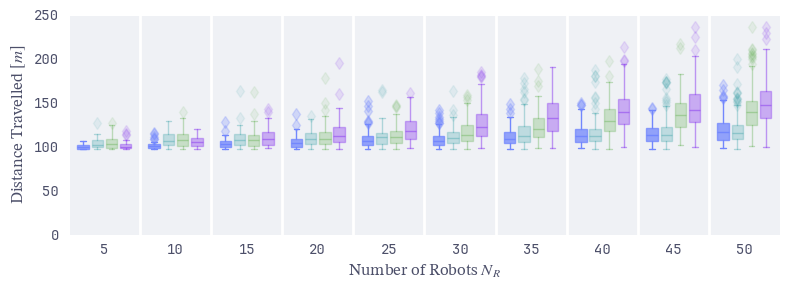

In [5]:

# plot distance travelled
fig, ax = plt.subplots(figsize=(8, 3))

# set font family
# ax.set_title('Distance Travelled by Robots', fontsize=14)

def set_box_plot_color(bp, color, alpha):
    # style the outliers
    # plt.setp(bp['fliers'], color=color, markersize=3, marker='.')
    # above color is not working, they are all black do this instead:
    for flier in bp['fliers']:
        flier.set(marker='d', markerfacecolor=color, markeredgecolor=None, alpha=0.5 * alpha)

    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        base_alpha = 1.0
        if element == 'boxes':
            base_alpha = 0.75
        elif element == 'fliers':
            base_alpha = 0.25
        plt.setp(bp[element], color=color, alpha=base_alpha * alpha)

print(f"{colors=}")

offset = 0.2

for i, (d, (c, alpha, _, _)) in enumerate(zip(data, colors)):
    distance_data = d['distance']
    labels = d['labels_distance']
    # ax.boxplot(distance_data, labels=labels, **boxplot_opts)

    bp = ax.boxplot(distance_data, positions=np.array(range(1, len(distance_data) + 1)) + i * offset - offset*1.5, widths=offset * 0.8, patch_artist=True)
    # bp = sns.boxplot(distance_data, positions=np.array(range(1, len(distance_data) + 1)) + i * offset - offset, widths=offset * 0.9, patch_artist=True)
    set_box_plot_color(bp, c, alpha)


# ax.boxplot(data, labels=labels, **boxplot_opts)

# violin_parts = plt.violinplot(data, showmeans=False, showmedians=True)

ax.set_xlabel(r'Number of Robots $N_R$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.set_ylabel(r'Distance Travelled $[m]$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.tick_params(axis='both', which='major', labelsize=10)

# set xticks and xticklabels 1,...,10
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})
ax.set_yticks(range(0, 251, 50))
ax.set_yticklabels(range(0, 251, 50), fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

# vertical lines inbetween all xticks
for i in range(1, len(labels)):
    ax.axvline(x=i + 0.5, color='white', linewidth=2)

# remove grid
ax.grid(False)

ax.set_ylim(0, 250)
ax.set_xlim(0.5, len(labels) + 0.5)

fig.patch.set_facecolor((0, 0, 0, 0))
# Draw optimal line
# ax.axhline(y=100, color=flavor.overlay2.hex, linestyle='--', linewidth=1.5)

fig.tight_layout()
fig.savefig('./scripts/out/circle-experiment-distance-travelled.svg')


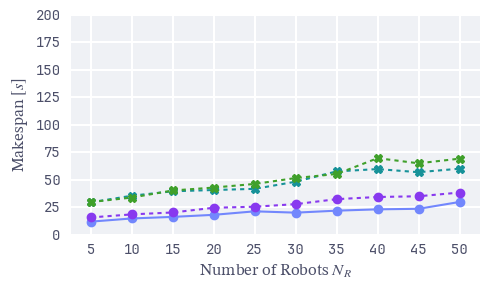

In [6]:

# plot makespan
fig, ax = plt.subplots(figsize=(5, 3))
for i, (d, (c, a, ls, marker)) in enumerate(zip(data, colors)):
    aggregated_data_makespan = d['makespan']
    makespan_data = [aggregated_data_makespan[key] for key in sorted(aggregated_data_makespan.keys())]
    labels = sorted(aggregated_data_makespan.keys())
    makespan_data = [np.mean(makespan) for makespan in makespan_data]

    ax.plot(labels, makespan_data, marker=marker, color=c, label='Circle Scenario', dashes=ls)

# ax.set_aspect(1 / 1.414) # A4 paper
# ax.boxplot(data, labels=labels, flierprops=dict(marker='D', color='r', markersize=8))

# # change gridline thickness
# ax.spines['top'].set_linewidth(2)
# ax.spines['right'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

ax.set_xlabel(r'Number of Robots $N_R$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.set_ylabel(r'Makespan $[s]$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.tick_params(axis='both', which='major', labelsize=10)

# x ticks
ax.set_xticks(range(0, 51, 5))
ax.set_xticklabels(range(0, 51, 5), fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})
# ax.set_xticklabels(labels, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

# y ticks
ax.set_yticks(range(0, 201, 25))
ax.set_yticklabels(range(0, 201, 25), fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

ax.set_ylim(0, 200)
ax.set_xlim(2.5, 52.5)

fig.tight_layout()
labels = ["$l_m$ = 3, $t_{K-1}$ = 5s", "$l_m$ = 1, $t_{K-1}$ = 13.33s", "$l_m$ = 3, $t_{K-1}$ = 13.33s"]
# legend = ax.legend(borderpad=0.5, framealpha=0.8, frameon=True)
# legend = ax.legend(labels, loc='upper right', borderpad=0.5, framealpha=0.8, frameon=True)
# set text color to [flavor.lavender.hex, flavor.yellow.hex, flavor.peach.hex]
# c = [(flavor.lavender.hex), flavor.yellow.hex, flavor.peach.hex]
# for (text, (c, a)) in zip(legend.get_texts(), colors):
#     text.set_color(c)
#     text.set_alpha(min(a + 0.25, 1))


fig.patch.set_facecolor((0, 0, 0, 0))
# make gridlines thicker
ax.grid(True, which='major', linewidth=1.5, color="white")

# legend.get_frame().set_facecolor(flavor.surface0.hex)  # Change background color
# plt.tight_layout()
fig.savefig('./scripts/out/circle-experiment-makespan.svg')


/tmp/ipykernel_57682/3766537627.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


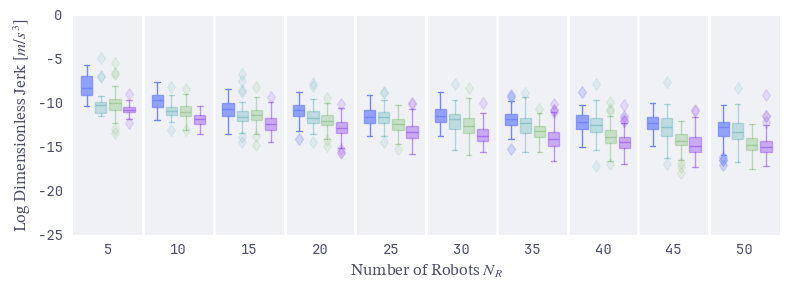

In [7]:


# plot ldj
fig, ax = plt.subplots(figsize=(8, 3))

for i, d in enumerate(data):
    aggregated_data_ldj = d['ldj']
    data_ldj = [aggregated_data_ldj[key] for key in sorted(aggregated_data_ldj.keys())]
    labels = sorted(aggregated_data_ldj.keys())
    # ax.boxplot(data_ldj, labels=labels, **boxplot_opts)
    bp = ax.boxplot(data_ldj, positions=np.array(range(1, len(data_ldj) + 1)) + i * offset - offset*1.5, widths=offset * 0.8, patch_artist=True)
    set_box_plot_color(bp, colors[i][0], colors[i][1])

ax.set_ylim(-25, 0)
# ax.set_aspect(1 / 1.414) # A4 paper
ax.set_xlabel(r'Number of Robots $N_R$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.set_ylabel(r'Log Dimensionless Jerk $[m/s^3]$', fontsize=12, fontdict={'color': flavor.text.hex})
ax.tick_params(axis='both', which='major', labelsize=10)

# set xticks and xticklabels 1,...,10
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

# y ricks
ax.set_yticks(range(-25, 1, 5))
ax.set_yticklabels(range(-25, 1, 5), fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})

# vertical lines inbetween all xticks
for i in range(1, len(labels)):
    ax.axvline(x=i + 0.5, color='white', linewidth=2)

# set xlim
ax.set_xlim(0.5, len(labels) + 0.5)

# remove grid
ax.grid(False)


fig.patch.set_facecolor((0, 0, 0, 0))

fig.tight_layout()
fig.savefig('./scripts/out/circle-experiment-ldj.svg')

fig.show()